In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats
from scipy import optimize
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from sklearn.feature_selection import f_regression
import dyl_function_slope as dyl
from cftime import num2date
import cmaps

In [2]:
equence_font={
    'style': "Helvetica",
    'weight': "bold",
    'fontsize':7
}
plt.rcParams['font.family'] = 'Helvetica'
ccmap = cmaps.cmp_b2r

In [3]:
def plot_meri_section(ax,era5_lon,era5_level,era5_level_label,
                      trend,mean_clim,level_range,level_range_clim,significant_points,
                      title1,title2,sequence):
    cycle_data, cycle_mon = add_cyclic_point(trend, coord=era5_lon)
    cycle_MON, cycle_LEVEL = np.meshgrid(cycle_mon, np.arange(era5_level.shape[0]))
    cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)
    ax1 = ax
    c1 = ax1.contourf(cycle_MON, cycle_LEVEL, cycle_data, cmap=ccmap, levels=level_range, extend='both')
    cycle_clim, cycle_mon = add_cyclic_point(mean_clim, coord=era5_lon)
    c3 = ax1.contour(cycle_MON, cycle_LEVEL, cycle_clim, levels=level_range_clim, colors='k', alpha=0.6,
                     linewidths=1)
    ax1.clabel(c3, inline=True, fontsize=6)
    cycle_dot, cycle_mon = add_cyclic_point(significant_points, coord=era5_lon)
    significance = np.ma.masked_where(cycle_dot > 0.05, cycle_dot)
    c3 = ax1.contourf(cycle_MON, cycle_LEVEL, significance, colors='none', hatches=['////'])

    if hasattr(c3, 'collections'):
        collections = c3.collections
    else:
        collections = [c3]
    # 设置 hatch 样式
    for collection in collections:
        collection.set_edgecolor('grey')
        collection.set_linewidth(0)

    ax1.clabel(c3, inline=True, fontsize=6)
    ax1.set_xticks([10,30,50,70])  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(era5_level.shape[0]), era5_level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='x', labelsize=7)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='y', labelsize=7)  # 设置y轴刻度数字大小
    ax1.set_title(title1, loc='left', fontsize=7)
    ax1.set_title(title2, loc='right', fontsize=7)
    ax1.set_ylabel('hPa', fontsize=7)
    ax1.text(-0.2, 1.15, sequence, transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    return c1

In [4]:
selected_plevs = [10, 50., 100., 150., 200., 250., 300.,500., 600.]

In [5]:

# 2. era5
print("------------Processing ERA5------------")
ds_ERA5_u = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_195801-202312.nc')
ds_selected = ds_ERA5_u.sel(time=slice('1980-01-01', '2020-12-31'))
# 筛选对应气压层值
ds_selected = ds_selected.sel(level=selected_plevs, method='nearest')
# 确保气压层是降序排列
ds_selected = ds_selected.reindex(level=ds_selected.level[::-1])
ds_selected = ds_selected.reindex(latitude=ds_selected.latitude[::-1])
#3 挑选北纬10-80n
ds_selected = ds_selected.sel(latitude=slice(10,80))

era5_u = ds_selected['u']
# 1. 获取原始的经度范围
original_lon = era5_u.longitude
# 2. 将原本0-360的经度转换为-180到180
new_lon = ((original_lon + 180) % 360) - 180
sorted_lon = np.concatenate([new_lon[new_lon < 0], new_lon[new_lon >= 0]])
# 将数据切分为两个部分：
# 1. 经度为180到360的部分
# 2. 经度为0到180的部分
# 使用 where 来确保包括 lon=180 和 lon=360
data_180_360 = era5_u.where((era5_u.longitude >= 180) & (era5_u.longitude <= 360), drop=True)
data_0_180 = era5_u.where((era5_u.longitude >= 0) & (era5_u.longitude < 180), drop=True)
# 合并这两部分，使得数据的经度顺序为180到360在前，0到180在后
era5_u = xr.concat([data_180_360, data_0_180], dim='longitude')
# 重新设置经度坐标
era5_u = era5_u.assign_coords(longitude=sorted_lon)
del ds_selected
# 4. 检查结果

level = era5_u.level[1:-1]
level_label = list(map(int, level.data.tolist()))
era5_lat = era5_u.latitude

era5_u = era5_u.mean(dim='longitude',skipna=True)

print(era5_u.level)
print(era5_u.latitude)
u_upminuslow = era5_u[:,2:].values - era5_u[:,0:-2].values
era5_upminuslow_trend, era5_upminuslow_p_values = dyl.calculate_trend_3D_ndarray(u_upminuslow)


------------Processing ERA5------------
<xarray.DataArray 'level' (level: 9)> Size: 36B
array([600, 500, 300, 250, 200, 150, 100,  50,  10], dtype=int32)
Coordinates:
  * level    (level) int32 36B 600 500 300 250 200 150 100 50 10
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z
<xarray.DataArray 'latitude' (latitude: 281)> Size: 1kB
array([10.  , 10.25, 10.5 , ..., 79.5 , 79.75, 80.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 1kB 10.0 10.25 10.5 10.75 ... 79.5 79.75 80.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y


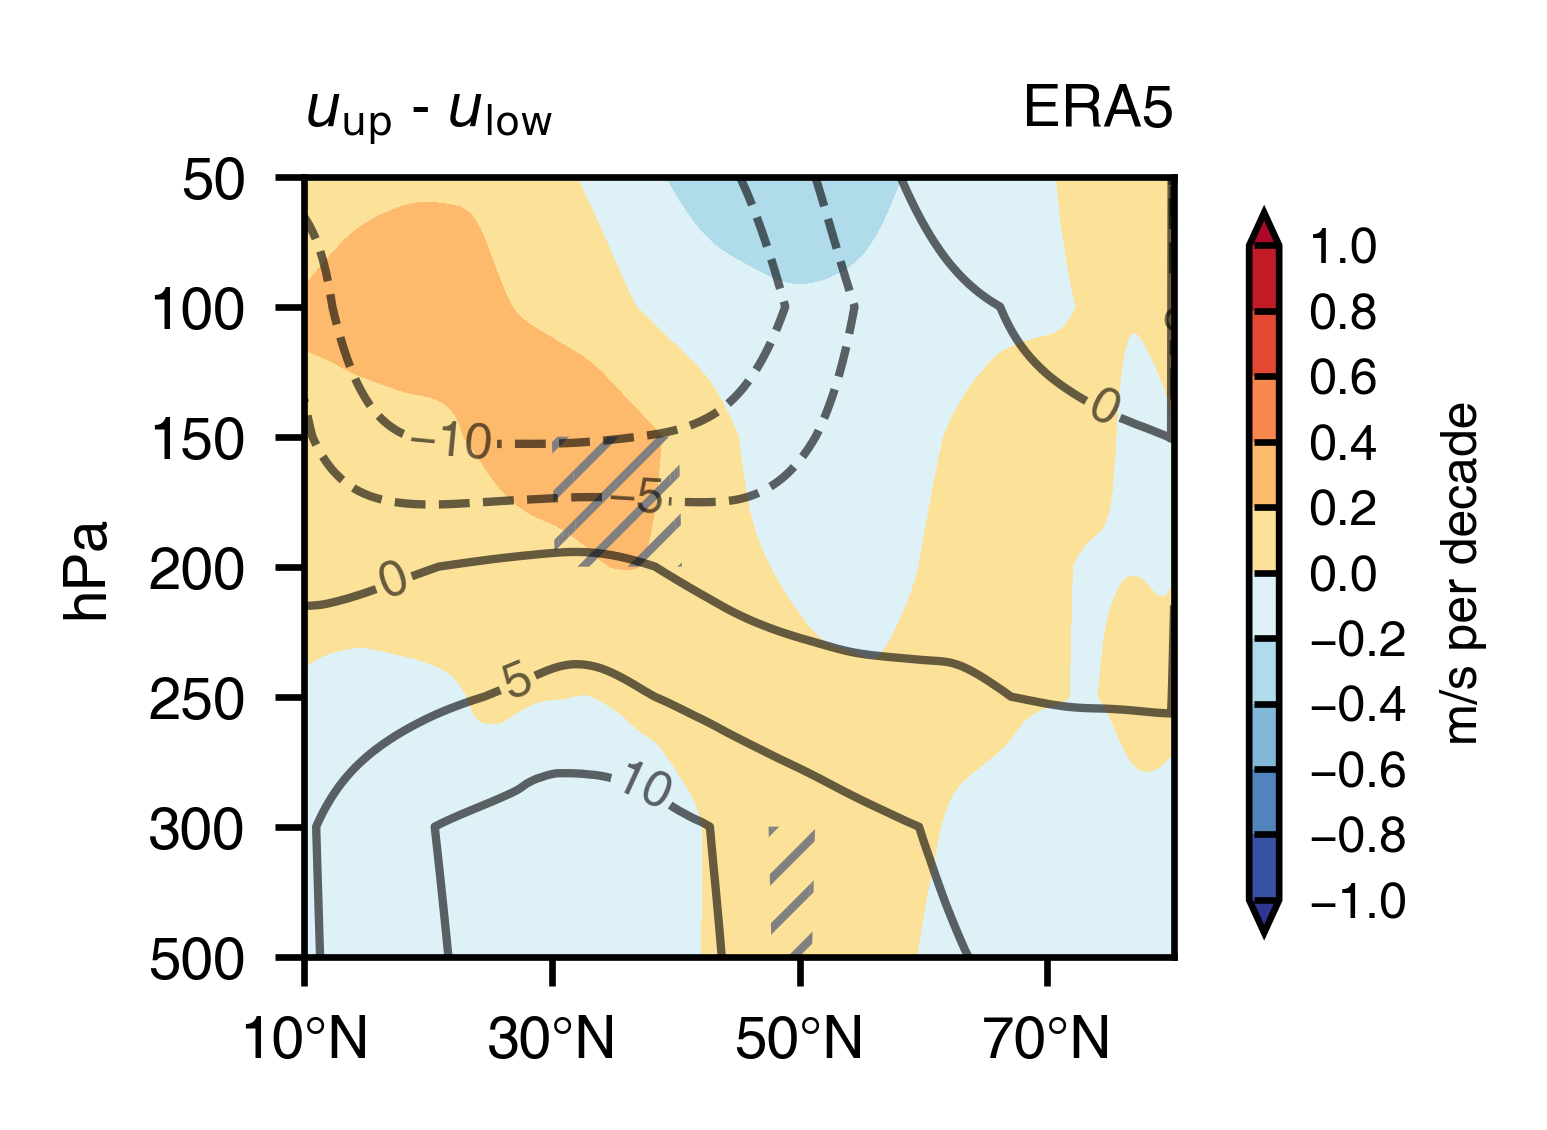

In [6]:
fig = plt.figure(figsize=(2.5, 2), dpi=600)
axes=[[0.17, 0.15, 0.58, 0.65]]
cf1 = plot_meri_section(fig.add_axes(axes[0]),era5_lat, level,level_label,
                        era5_upminuslow_trend*120,np.nanmean(u_upminuslow,axis=0),
                        np.arange(-1, 1.1, 0.2),np.arange(-10, 20, 5),era5_upminuslow_p_values,
                  r'$u_{\text{up}}$ - $u_{\text{low}}$','ERA5',' ')

cbar_ax = fig.add_axes([0.8, 0.17, 0.02, 0.6])  # 调整这些数字以改变colorbar的大小和位置
cb = plt.colorbar(cf1,cax=cbar_ax , orientation='vertical', shrink=0.85, pad=0.05, extend='both')
cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
cb.set_ticks(np.arange(-1, 1.1, 0.2))
# ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
cb.ax.tick_params(axis='y', which='major', direction='in', length=3, labelsize=6)
# cb.ax.tick_params(which='minor', direction='in', length=5)
cb.set_label(label=r'm/s per decade', fontsize=6)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S4.u_upminuslow_ERA5_trend_meri_sec.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S4.u_upminuslow_ERA5_trend_meri_sec.svg',format='svg',dpi=300)
plt.show()